<a href="https://colab.research.google.com/github/8sheeta8/Attack_Network_AI/blob/main/SSH-Bruteforce/SSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# CuDNN backward 오류 방지
import torch.backends.cudnn
torch.backends.cudnn.enabled = False

# ===== 데이터셋 클래스 =====
class ByteSequenceDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path, allow_pickle=True).astype(np.float32)
        self.data = (self.data / 127.5) - 1.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# ===== Generator (LSTM 기반) =====
class Generator(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=128, output_len=128):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(noise_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_len)

    def forward(self, z):
        out, _ = self.lstm(z)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out)

# ===== Discriminator (PacGAN2 + LSTM + WGAN-GP) =====
class PacDiscriminator(nn.Module):
    def __init__(self, input_len=128, hidden_dim=128, pac_num=2):
        super(PacDiscriminator, self).__init__()
        self.pac_num = pac_num
        self.lstm = nn.LSTM(input_len, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        B = x.size(0)
        if B % self.pac_num != 0:
            x = x[:B - (B % self.pac_num)]
            B = x.size(0)
        x = x.view(B // self.pac_num, self.pac_num, -1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# ===== Gradient Penalty 계산 =====
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ===== 샘플 생성 =====
def generate_samples(generator, noise_dim=100, num_samples=5):
    generator.eval()
    device = next(generator.parameters()).device

    with torch.no_grad():
        z = torch.randn(num_samples, 1, noise_dim, device=device)
        fake_data = generator(z)
        return fake_data.squeeze(1).cpu().numpy()

# train_model 수정 → 필요한 변수 함께 반환
def train_model(file_path, epochs=20, batch_size=64, noise_dim=100, pac_num=2, lambda_gp=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ByteSequenceDataset(file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = Generator(noise_dim=noise_dim).to(device)
    D = PacDiscriminator(pac_num=pac_num).to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):
            real_data = real_data.to(device)
            B = real_data.size(0)
            if B % pac_num != 0:
                real_data = real_data[:B - (B % pac_num)]
                B = real_data.size(0)

            # Discriminator 학습
            optimizer_D.zero_grad()
            z = torch.randn(B, 1, noise_dim).to(device)
            fake_data = G(z).detach()
            real_validity = D(real_data)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_data, fake_data, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Generator 학습
            if i % 5 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(B, 1, noise_dim).to(device)
                gen_data = G(z)
                g_loss = -torch.mean(D(gen_data))
                g_loss.backward()
                optimizer_G.step()

        print(f"[Epoch {epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    return G, dataloader, batch_size, noise_dim, device

In [ ]:
# 학습 및 반환
path = "/content/drive/MyDrive/eunsu/ssh.npy"
G, dataloader, batch_size, noise_dim, device = train_model(path, epochs=500)

# real 데이터 수집
real_samples = []
for real_batch in dataloader:
    real_samples.append(real_batch.detach().cpu().numpy())
real_samples = np.concatenate(real_samples, axis=0)

# fake 데이터 생성
fake_samples = []
G.eval()
with torch.no_grad():
    for _ in range(len(real_samples) // batch_size):
        z = torch.randn(batch_size, 1, noise_dim).to(device)
        gen = G(z).cpu().numpy()
        fake_samples.append(gen)
fake_samples = np.concatenate(fake_samples, axis=0)

# 저장
np.save("real_flat.npy", real_samples)
np.save("fake_flat.npy", fake_samples)
print("✅ 저장 완료: real_flat.npy / fake_flat.npy")
print(f"🔢 Shape - Real: {real_samples.shape}, Fake: {fake_samples.shape}")

[Epoch 1/500] D_loss: -12.1734, G_loss: 1.4331
[Epoch 2/500] D_loss: -11.2726, G_loss: 5.8361
[Epoch 3/500] D_loss: -7.8867, G_loss: 9.1467
[Epoch 4/500] D_loss: -8.3246, G_loss: 11.6941
[Epoch 5/500] D_loss: -8.0690, G_loss: 10.4064
[Epoch 6/500] D_loss: -8.2050, G_loss: 10.3883
[Epoch 7/500] D_loss: -7.8706, G_loss: 12.7568
[Epoch 8/500] D_loss: -8.6230, G_loss: 13.5004
[Epoch 9/500] D_loss: -8.8789, G_loss: 14.7492
[Epoch 10/500] D_loss: -8.2841, G_loss: 15.2141
[Epoch 11/500] D_loss: -8.1729, G_loss: 14.5790
[Epoch 12/500] D_loss: -7.7716, G_loss: 14.8441
[Epoch 13/500] D_loss: -7.0131, G_loss: 15.1960
[Epoch 14/500] D_loss: -8.3218, G_loss: 16.0575
[Epoch 15/500] D_loss: -7.3955, G_loss: 15.3921
[Epoch 16/500] D_loss: -7.5442, G_loss: 16.5212
[Epoch 17/500] D_loss: -7.8498, G_loss: 16.3821
[Epoch 18/500] D_loss: -6.0408, G_loss: 16.6225
[Epoch 19/500] D_loss: -7.6485, G_loss: 17.3028
[Epoch 20/500] D_loss: -6.2915, G_loss: 17.3029
[Epoch 21/500] D_loss: -6.4448, G_loss: 16.9900
[E

🎯 FID Score: 0.6200
✅ Accuracy: 0.5630
✅ F1 Score: 0.5701
✅ Confusion Matrix:
[[12906 10710]
 [ 9940 13694]]


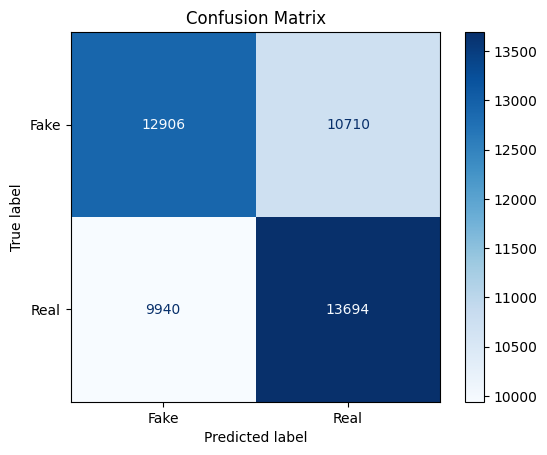

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):
    # 평균과 공분산 계산
    mu1, sigma1 = real.mean(axis=0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(axis=0), np.cov(fake, rowvar=False)

    # 평균 거리
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score = calculate_fid(real_samples, fake_samples)
print(f"🎯 FID Score: {fid_score:.4f}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# [1] 라벨링
X = np.vstack([real_samples, fake_samples])
y = np.array([1] * len(real_samples) + [0] * len(fake_samples))  # 1=real, 0=fake

# [2] 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# [3] 탐지기 학습
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# [4] 예측 및 평가
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# [5] 결과 출력
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:")
print(cm)

# [6] 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

🔍 t-SNE 임베딩 중...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


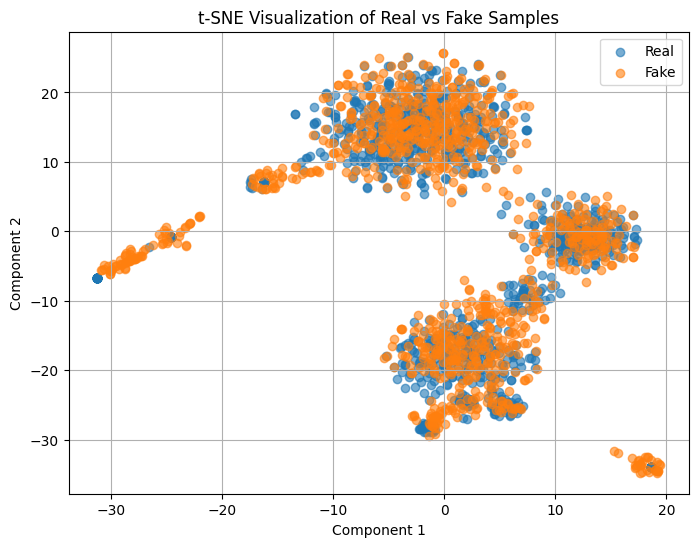

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(real_samples, fake_samples, sample_size=1000):
    # 샘플 크기 제한 (많을수록 느려짐)
    N = min(sample_size, len(real_samples), len(fake_samples))
    real = real_samples[:N]
    fake = fake_samples[:N]

    # 합치고 라벨링
    X = np.vstack([real, fake])
    y = np.array([0]*N + [1]*N)  # 0: real, 1: fake

    # t-SNE 임베딩
    print("🔍 t-SNE 임베딩 중...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca", random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label="Real", alpha=0.6)
    plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label="Fake", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Real vs Fake Samples")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

real_samples = np.load("real_flat.npy")
fake_samples = np.load("fake_flat.npy")

visualize_tsne(real_samples, fake_samples, sample_size=1000)

🔍 1. t-SNE 시각화 분석
t-SNE Visualization of Real vs Fake Samples를 보면:

파란색(Real)과 주황색(Fake)이 대부분 동일 클러스터 내에 섞여 있습니다.

일부 클러스터에서는 어느 정도 구분되는 경향도 보이지만, 전반적으로 분리도가 낮아 보입니다.

즉, 생성된 데이터가 실제 데이터를 어느 정도 잘 모방했지만, 완벽하게 동일한 분포를 따라가지는 않는다는 뜻입니다.

해석:
탐지기가 Real과 Fake을 구분하는 데 어려움을 겪고 있음 → 즉, 생성 데이터가 탐지기를 속이는 데 어느 정도 성공함
이는 "탐지기 회피 가능한 페이로드"라는 목표에 긍정적인 결과입니다.

===================================



✅ 최적화된 해결 방안
🔄 Minibatch Discrimination 제거
Minibatch Discrimination 없이도 PacGAN 구조 + Self-Attention Generator만으로도 탐지 회피에 상당한 효과를 낼 수 있습니다.

✳️ 업데이트된 계획
✅ Generator: LSTM + Self-Attention → 유지

✅ Discriminator: PacGAN2 구조(LSTM 기반)만 사용, MBD 제거 → 안정성 향상

📝 요약
Generator는 LSTM + Self-Attention 구조로 더 복잡한 시퀀스를 생성할 수 있도록 개선됨

Discriminator는 PacGAN 구조를 유지하되, Minibatch Discrimination은 제외하여 메모리 문제 해결
이전 모델에서 진행 내용

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# CuDNN 오류 방지
import torch.backends.cudnn
torch.backends.cudnn.enabled = False

# ===== 데이터셋 클래스 =====
class ByteSequenceDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path, allow_pickle=True).astype(np.float32)
        self.data = (self.data / 127.5) - 1.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# ===== Self-Attention 모듈 =====
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, V)

# ===== 개선된 Generator =====
class ImprovedGenerator(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=128, output_len=128):
        super(ImprovedGenerator, self).__init__()
        self.lstm = nn.LSTM(noise_dim, hidden_dim, batch_first=True)
        self.attn = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_len)

    def forward(self, z):
        out, _ = self.lstm(z)
        out = self.attn(out)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out)

# ===== 개선된 Discriminator (PacGAN2) =====
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_len=128, hidden_dim=128, pac_num=2):
        super(ImprovedDiscriminator, self).__init__()
        self.pac_num = pac_num
        self.lstm = nn.LSTM(input_len, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        B = x.size(0)
        if B % self.pac_num != 0:
            x = x[:B - (B % self.pac_num)]
            B = x.size(0)
        x = x.view(B // self.pac_num, self.pac_num, -1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ===== Gradient Penalty =====
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ===== 학습 함수 =====
def train_model_v2(file_path, epochs=20, batch_size=64, noise_dim=100, pac_num=2, lambda_gp=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ByteSequenceDataset(file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = ImprovedGenerator(noise_dim=noise_dim).to(device)
    D = ImprovedDiscriminator(pac_num=pac_num).to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):
            real_data = real_data.to(device)
            B = real_data.size(0)
            if B % pac_num != 0:
                real_data = real_data[:B - (B % pac_num)]
                B = real_data.size(0)

            # Discriminator 학습
            optimizer_D.zero_grad()
            z = torch.randn(B, 1, noise_dim).to(device)
            fake_data = G(z).detach()
            real_validity = D(real_data)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_data, fake_data, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Generator 학습
            if i % 5 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(B, 1, noise_dim).to(device)
                gen_data = G(z)
                g_loss = -torch.mean(D(gen_data))
                g_loss.backward()
                optimizer_G.step()

        print(f"[Epoch {epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    return G, dataloader, batch_size, noise_dim, device

In [ ]:
# 학습 및 반환
path = "/content/drive/MyDrive/eunsu/ssh.npy"
G, dataloader, batch_size, noise_dim, device = train_model_v2(path, epochs=1000)

# real 데이터 수집
real_samples = []
for real_batch in dataloader:
    real_samples.append(real_batch.detach().cpu().numpy())
real_samples = np.concatenate(real_samples, axis=0)

# fake 데이터 생성
fake_samples = []
G.eval()
with torch.no_grad():
    for _ in range(len(real_samples) // batch_size):
        z = torch.randn(batch_size, 1, noise_dim).to(device)
        gen = G(z).cpu().numpy()
        fake_samples.append(gen)
fake_samples = np.concatenate(fake_samples, axis=0)

# 저장
np.save("real_flat.npy", real_samples)
np.save("fake_flat.npy", fake_samples)
print("✅ 저장 완료: real_flat.npy / fake_flat.npy")
print(f"🔢 Shape - Real: {real_samples.shape}, Fake: {fake_samples.shape}")

[Epoch 1/1000] D_loss: -8.3521, G_loss: 2.4382
[Epoch 2/1000] D_loss: -5.9098, G_loss: 10.7243
[Epoch 3/1000] D_loss: -7.7507, G_loss: 6.7365
[Epoch 4/1000] D_loss: -9.4328, G_loss: 10.7721
[Epoch 5/1000] D_loss: -7.8406, G_loss: 13.1891
[Epoch 6/1000] D_loss: -10.1025, G_loss: 15.0235
[Epoch 7/1000] D_loss: -9.6815, G_loss: 15.3801
[Epoch 8/1000] D_loss: -9.7162, G_loss: 14.1377
[Epoch 9/1000] D_loss: -8.8222, G_loss: 13.3955
[Epoch 10/1000] D_loss: -8.9811, G_loss: 13.3132
[Epoch 11/1000] D_loss: -7.4421, G_loss: 13.0348
[Epoch 12/1000] D_loss: -9.2967, G_loss: 14.0048
[Epoch 13/1000] D_loss: -9.2123, G_loss: 13.6577
[Epoch 14/1000] D_loss: -6.9521, G_loss: 13.9608
[Epoch 15/1000] D_loss: -10.1257, G_loss: 14.4171
[Epoch 16/1000] D_loss: -8.5193, G_loss: 14.1065
[Epoch 17/1000] D_loss: -8.8677, G_loss: 14.7337
[Epoch 18/1000] D_loss: -7.7737, G_loss: 14.2882
[Epoch 19/1000] D_loss: -8.7905, G_loss: 14.2411
[Epoch 20/1000] D_loss: -8.0364, G_loss: 14.5572
[Epoch 21/1000] D_loss: -9.01

🎯 FID Score: 2.7331
✅ Accuracy: 0.6949
✅ F1 Score: 0.7057
✅ Confusion Matrix:
[[15558  8058]
 [ 6356 17278]]


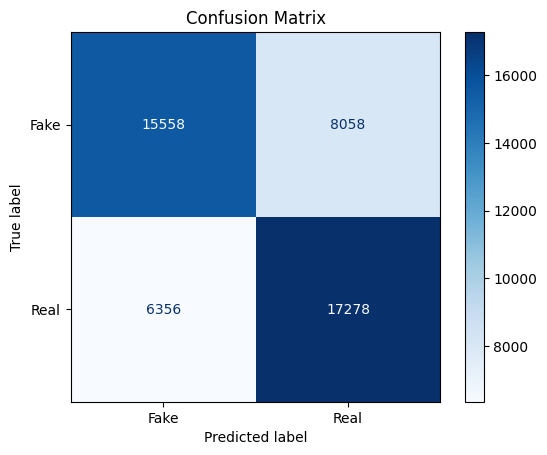

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):
    # 평균과 공분산 계산
    mu1, sigma1 = real.mean(axis=0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(axis=0), np.cov(fake, rowvar=False)

    # 평균 거리
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score = calculate_fid(real_samples, fake_samples)
print(f"🎯 FID Score: {fid_score:.4f}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# [1] 라벨링
X = np.vstack([real_samples, fake_samples])
y = np.array([1] * len(real_samples) + [0] * len(fake_samples))  # 1=real, 0=fake

# [2] 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# [3] 탐지기 학습
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# [4] 예측 및 평가
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# [5] 결과 출력
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:")
print(cm)

# [6] 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

🔍 t-SNE 임베딩 중...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


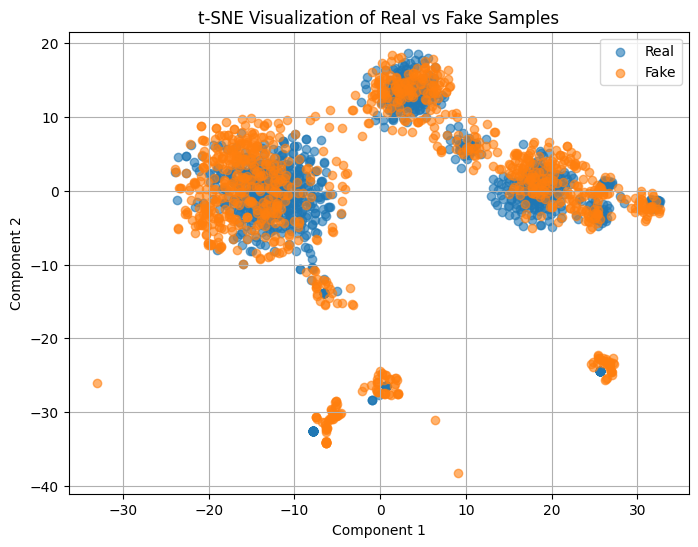

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(real_samples, fake_samples, sample_size=1000):
    # 샘플 크기 제한 (많을수록 느려짐)
    N = min(sample_size, len(real_samples), len(fake_samples))
    real = real_samples[:N]
    fake = fake_samples[:N]

    # 합치고 라벨링
    X = np.vstack([real, fake])
    y = np.array([0]*N + [1]*N)  # 0: real, 1: fake

    # t-SNE 임베딩
    print("🔍 t-SNE 임베딩 중...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca", random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label="Real", alpha=0.6)
    plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label="Fake", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Real vs Fake Samples")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

real_samples = np.load("real_flat.npy")
fake_samples = np.load("fake_flat.npy")

visualize_tsne(real_samples, fake_samples, sample_size=1000)

🔍 t-SNE 시각화 해석
Real과 Fake이 클러스터 내에서 상당히 겹쳐져 있음.

일부 클러스터에서는 Fake이 Real보다 더 중심부에 분포함 → 분포 모방이 잘 됨.

전체적으로 모양과 분포가 실제 데이터와 유사하게 구성됨.

📌 결론
Self-Attention + PacGAN2 구조는 현재 상태에서 탐지기 회피 가능한 페이로드 생성 목적에 부합하며, 이전보다 더 높은 F1/Accuracy를 기록하면서도 FID도 괜찮은 수준을 유지하고 있습니다.

# 222222222222222222222

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.nn.utils import spectral_norm

# CuDNN 오류 방지
import torch.backends.cudnn
torch.backends.cudnn.enabled = False

# ===== 데이터셋 클래스 =====
class ByteSequenceDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path, allow_pickle=True).astype(np.float32)
        self.data = (self.data / 127.5) - 1.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# ===== Self-Attention 모듈 =====
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, V)

# ===== 개선된 Generator =====
class ImprovedGenerator(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=128, output_len=128):
        super(ImprovedGenerator, self).__init__()
        self.lstm = nn.LSTM(noise_dim, hidden_dim, batch_first=True)
        self.attn = SelfAttention(hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_len)

    def forward(self, z):
        out, _ = self.lstm(z)
        out = self.attn(out)
        out = self.norm(out)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out)

# ===== 개선된 Discriminator (PacGAN3 + SpectralNorm) =====
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_len=128, hidden_dim=128, pac_num=3):
        super(ImprovedDiscriminator, self).__init__()
        self.pac_num = pac_num
        self.lstm = nn.LSTM(input_len, hidden_dim, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc = spectral_norm(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        B = x.size(0)
        if B % self.pac_num != 0:
            x = x[:B - (B % self.pac_num)]
            B = x.size(0)
        x = x.view(B // self.pac_num, self.pac_num, -1)
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)

# ===== Gradient Penalty =====
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ===== 학습 함수 =====
def train_model_v3(file_path, epochs=20, batch_size=64, noise_dim=100, pac_num=3, lambda_gp=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ByteSequenceDataset(file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = ImprovedGenerator(noise_dim=noise_dim).to(device)
    D = ImprovedDiscriminator(pac_num=pac_num).to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):
            real_data = real_data.to(device)
            B = real_data.size(0)
            if B % pac_num != 0:
                real_data = real_data[:B - (B % pac_num)]
                B = real_data.size(0)

            # Discriminator 학습
            optimizer_D.zero_grad()
            z = torch.randn(B, 1, noise_dim).to(device)
            fake_data = G(z).detach()
            real_validity = D(real_data)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_data, fake_data, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Generator 학습
            if i % 5 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(B, 1, noise_dim).to(device)
                gen_data = G(z)
                g_loss = -torch.mean(D(gen_data))
                g_loss.backward()
                optimizer_G.step()

        print(f"[Epoch {epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    return G, dataloader, batch_size, noise_dim, device


In [ ]:
# 학습 및 반환
path = "/content/drive/MyDrive/eunsu/ssh.npy"
G, dataloader, batch_size, noise_dim, device = train_model_v3(path, epochs=1000)

# real 데이터 수집
real_samples = []
for real_batch in dataloader:
    real_samples.append(real_batch.detach().cpu().numpy())
real_samples = np.concatenate(real_samples, axis=0)

# fake 데이터 생성
fake_samples = []
G.eval()
with torch.no_grad():
    for _ in range(len(real_samples) // batch_size):
        z = torch.randn(batch_size, 1, noise_dim).to(device)
        gen = G(z).cpu().numpy()
        fake_samples.append(gen)
fake_samples = np.concatenate(fake_samples, axis=0)

# 저장
np.save("real_flat.npy", real_samples)
np.save("fake_flat.npy", fake_samples)
print("✅ 저장 완료: real_flat.npy / fake_flat.npy")
print(f"🔢 Shape - Real: {real_samples.shape}, Fake: {fake_samples.shape}")

[Epoch 1/1000] D_loss: -5.9360, G_loss: 8.5975
[Epoch 2/1000] D_loss: -6.5929, G_loss: 5.2247
[Epoch 3/1000] D_loss: -6.8821, G_loss: 7.2729
[Epoch 4/1000] D_loss: -7.2430, G_loss: 6.3339
[Epoch 5/1000] D_loss: -8.5262, G_loss: 6.9011
[Epoch 6/1000] D_loss: -7.4793, G_loss: 7.2897
[Epoch 7/1000] D_loss: -6.5679, G_loss: 7.7272
[Epoch 8/1000] D_loss: -6.2749, G_loss: 8.6728
[Epoch 9/1000] D_loss: -9.0595, G_loss: 8.2655
[Epoch 10/1000] D_loss: -5.5324, G_loss: 8.9453
[Epoch 11/1000] D_loss: -7.1304, G_loss: 9.4535
[Epoch 12/1000] D_loss: -6.9669, G_loss: 9.5563
[Epoch 13/1000] D_loss: -6.6675, G_loss: 9.7227
[Epoch 14/1000] D_loss: -4.7233, G_loss: 10.3415
[Epoch 15/1000] D_loss: -8.6882, G_loss: 10.6234
[Epoch 16/1000] D_loss: -7.3953, G_loss: 10.4654
[Epoch 17/1000] D_loss: -8.0605, G_loss: 10.2131
[Epoch 18/1000] D_loss: -6.3188, G_loss: 10.4429
[Epoch 19/1000] D_loss: -6.1172, G_loss: 10.9998
[Epoch 20/1000] D_loss: -6.4874, G_loss: 11.2700
[Epoch 21/1000] D_loss: -6.9187, G_loss: 1

🎯 FID Score: 16.8473
✅ Accuracy: 0.9708
✅ F1 Score: 0.9704
✅ Confusion Matrix:
[[23317   299]
 [ 1079 22555]]


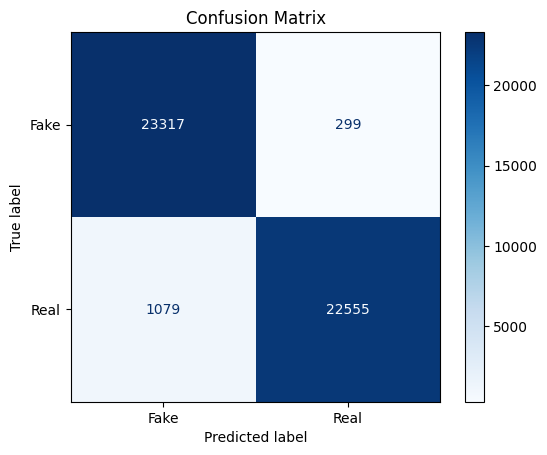

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):
    # 평균과 공분산 계산
    mu1, sigma1 = real.mean(axis=0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(axis=0), np.cov(fake, rowvar=False)

    # 평균 거리
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score = calculate_fid(real_samples, fake_samples)
print(f"🎯 FID Score: {fid_score:.4f}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# [1] 라벨링
X = np.vstack([real_samples, fake_samples])
y = np.array([1] * len(real_samples) + [0] * len(fake_samples))  # 1=real, 0=fake

# [2] 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# [3] 탐지기 학습
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# [4] 예측 및 평가
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# [5] 결과 출력
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:")
print(cm)

# [6] 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

🔍 t-SNE 임베딩 중...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


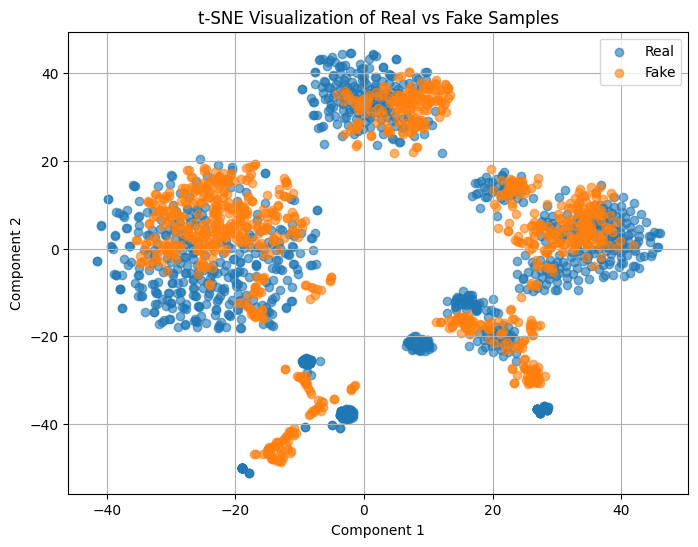

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(real_samples, fake_samples, sample_size=1000):
    # 샘플 크기 제한 (많을수록 느려짐)
    N = min(sample_size, len(real_samples), len(fake_samples))
    real = real_samples[:N]
    fake = fake_samples[:N]

    # 합치고 라벨링
    X = np.vstack([real, fake])
    y = np.array([0]*N + [1]*N)  # 0: real, 1: fake

    # t-SNE 임베딩
    print("🔍 t-SNE 임베딩 중...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca", random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label="Real", alpha=0.6)
    plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label="Fake", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Real vs Fake Samples")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

real_samples = np.load("real_flat.npy")
fake_samples = np.load("fake_flat.npy")

visualize_tsne(real_samples, fake_samples, sample_size=1000)

🎯 FID Score	16.8473	이전보다 많이 상승 → 생성 샘플과 실제 데이터 간 통계적 차이가 커짐
✅ Accuracy	97.08%	탐지기가 Real/Fake을 매우 잘 구분함
✅ F1 Score	97.04%	높은 분류 성능 → 생성 데이터가 쉽게 탐지됨
✅ Confusion Matrix	[[23317 299], [1079 22555]]	Fake 중 1,079건을 Real로 오탐 (탐지 회피 실패)

🔍 t-SNE 시각화 해석
Real(파란색)과 Fake(주황색)이 거의 완전히 분리됨

일부 클러스터에서만 약간의 겹침 존재

→ 생성된 샘플이 현실적인 분포를 따르지 않음 (FID가 이를 수치로 뒷받침)

📉 원인 분석
현재 적용된 개선점(PacGAN3, LayerNorm, SpectralNorm 등)은 학습 안정성과 분별 능력 향상에 효과적이지만, 그 결과:

Discriminator가 너무 강해짐
→ Generator가 Discriminator를 속이지 못하고, 단순/안전한 패턴만 생성
→ FID는 상승, 탐지 회피 실패

# ==========================
# 33333333333333333333333333

✅ pac_num을 2로 낮춰 탐지기 분별력 조정

✅ Generator의 Dropout 비율을 0.5로 증가

✅ Generator 학습을 Discriminator와 동일 비율(n_critic = 1)로 조정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.nn.utils import spectral_norm

# CuDNN 오류 방지
import torch.backends.cudnn
torch.backends.cudnn.enabled = False

# ===== 데이터셋 클래스 =====
class ByteSequenceDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path, allow_pickle=True).astype(np.float32)
        self.data = (self.data / 127.5) - 1.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# ===== Self-Attention 모듈 =====
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, V)

# ===== 개선된 Generator =====
class ImprovedGenerator(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=128, output_len=128):
        super(ImprovedGenerator, self).__init__()
        self.lstm = nn.LSTM(noise_dim, hidden_dim, batch_first=True)
        self.attn = SelfAttention(hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)  # Dropout 비율 증가
        self.fc = nn.Linear(hidden_dim, output_len)

    def forward(self, z):
        out, _ = self.lstm(z)
        out = self.attn(out)
        out = self.norm(out)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out)

# ===== 개선된 Discriminator (PacGAN2 + SpectralNorm) =====
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_len=128, hidden_dim=128, pac_num=2):
        super(ImprovedDiscriminator, self).__init__()
        self.pac_num = pac_num
        self.lstm = nn.LSTM(input_len, hidden_dim, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc = spectral_norm(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        B = x.size(0)
        if B % self.pac_num != 0:
            x = x[:B - (B % self.pac_num)]
            B = x.size(0)
        x = x.view(B // self.pac_num, self.pac_num, -1)
        out, _ = self.lstm(x)
        out = self.norm(out[:, -1, :])
        return self.fc(out)

# ===== Gradient Penalty =====
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ===== 학습 함수 =====
def train_model_v4(file_path, epochs=20, batch_size=64, noise_dim=100, pac_num=2, lambda_gp=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ByteSequenceDataset(file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = ImprovedGenerator(noise_dim=noise_dim).to(device)
    D = ImprovedDiscriminator(pac_num=pac_num).to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):
            real_data = real_data.to(device)
            B = real_data.size(0)
            if B % pac_num != 0:
                real_data = real_data[:B - (B % pac_num)]
                B = real_data.size(0)

            # Discriminator 학습
            optimizer_D.zero_grad()
            z = torch.randn(B, 1, noise_dim).to(device)
            fake_data = G(z).detach()
            real_validity = D(real_data)
            fake_validity = D(fake_data)
            gp = compute_gradient_penalty(D, real_data, fake_data, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Generator 학습 (n_critic = 1)
            optimizer_G.zero_grad()
            z = torch.randn(B, 1, noise_dim).to(device)
            gen_data = G(z)
            g_loss = -torch.mean(D(gen_data))
            g_loss.backward()
            optimizer_G.step()

        print(f"[Epoch {epoch+1}/{epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    return G, dataloader, batch_size, noise_dim, device

In [ ]:
# 학습 및 반환
path = "/content/drive/MyDrive/eunsu/ssh.npy"
G, dataloader, batch_size, noise_dim, device = train_model_v4(path, epochs=1000)

# real 데이터 수집
real_samples = []
for real_batch in dataloader:
    real_samples.append(real_batch.detach().cpu().numpy())
real_samples = np.concatenate(real_samples, axis=0)

# fake 데이터 생성
fake_samples = []
G.eval()
with torch.no_grad():
    for _ in range(len(real_samples) // batch_size):
        z = torch.randn(batch_size, 1, noise_dim).to(device)
        gen = G(z).cpu().numpy()
        fake_samples.append(gen)
fake_samples = np.concatenate(fake_samples, axis=0)

# 저장
path2 = "/content/drive/MyDrive/eunsu/방학중/"
np.save(path2 + "real_ssh_4.npy", real_samples)
np.save(path2 + "fake_ssh_4.npy", fake_samples)
print("✅ 저장 완료: real_ssh_4.npy / fake_ssh_4.npy")
print(f"🔢 Shape - Real: {real_samples.shape}, Fake: {fake_samples.shape}")

[Epoch 1/1000] D_loss: -1.3543, G_loss: 0.5138
[Epoch 2/1000] D_loss: -2.1349, G_loss: 0.6451
[Epoch 3/1000] D_loss: -1.9850, G_loss: 1.7084
[Epoch 4/1000] D_loss: -1.9624, G_loss: 2.0436
[Epoch 5/1000] D_loss: -2.7027, G_loss: 1.5843
[Epoch 6/1000] D_loss: -2.2622, G_loss: 1.4390
[Epoch 7/1000] D_loss: -2.1064, G_loss: 1.0904
[Epoch 8/1000] D_loss: -2.0684, G_loss: 1.1087
[Epoch 9/1000] D_loss: -2.0695, G_loss: 1.8263
[Epoch 10/1000] D_loss: -1.2195, G_loss: 1.6740
[Epoch 11/1000] D_loss: -1.7504, G_loss: 0.9103
[Epoch 12/1000] D_loss: -1.8300, G_loss: 1.1265
[Epoch 13/1000] D_loss: -1.0043, G_loss: -0.0694
[Epoch 14/1000] D_loss: -1.4043, G_loss: 0.5045
[Epoch 15/1000] D_loss: -1.5233, G_loss: 0.5743
[Epoch 16/1000] D_loss: -1.4200, G_loss: 0.1200
[Epoch 17/1000] D_loss: -2.0769, G_loss: -0.1489
[Epoch 18/1000] D_loss: -1.2864, G_loss: 0.5124
[Epoch 19/1000] D_loss: -1.4378, G_loss: 0.4564
[Epoch 20/1000] D_loss: -2.3737, G_loss: 0.7477
[Epoch 21/1000] D_loss: -1.8648, G_loss: 0.5435

🎯 FID Score: 22.5555
✅ Accuracy: 0.9756
✅ F1 Score: 0.9751
✅ Confusion Matrix:
[[23517    99]
 [ 1053 22581]]


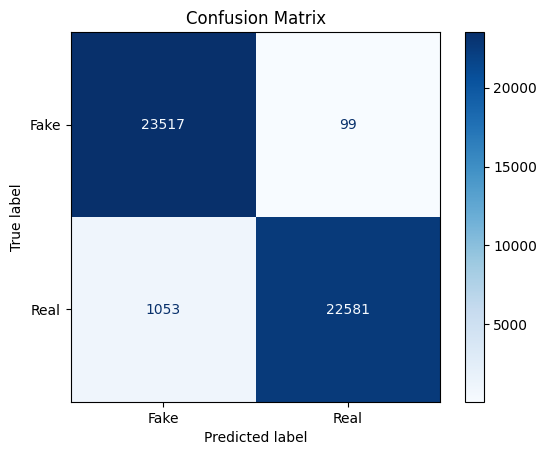

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):
    # 평균과 공분산 계산
    mu1, sigma1 = real.mean(axis=0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(axis=0), np.cov(fake, rowvar=False)

    # 평균 거리
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score = calculate_fid(real_samples, fake_samples)
print(f"🎯 FID Score: {fid_score:.4f}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# [1] 라벨링
X = np.vstack([real_samples, fake_samples])
y = np.array([1] * len(real_samples) + [0] * len(fake_samples))  # 1=real, 0=fake

# [2] 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# [3] 탐지기 학습
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# [4] 예측 및 평가
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# [5] 결과 출력
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:")
print(cm)

# [6] 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

🔍 t-SNE 임베딩 중...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


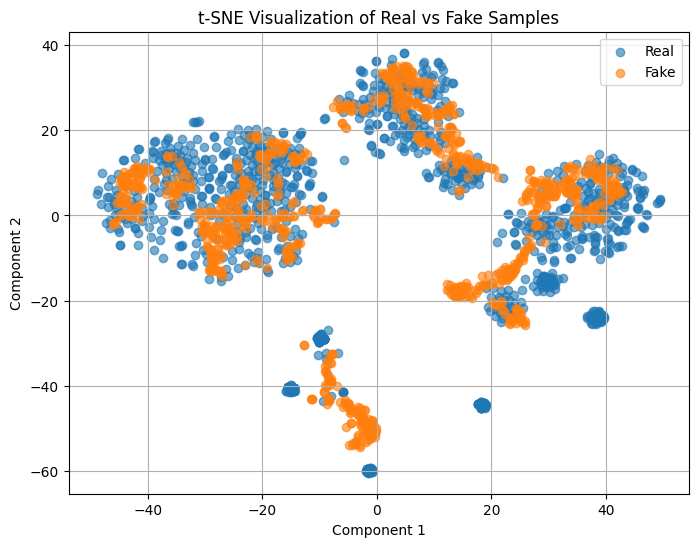

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(real_samples, fake_samples, sample_size=1000):
    # 샘플 크기 제한 (많을수록 느려짐)
    N = min(sample_size, len(real_samples), len(fake_samples))
    real = real_samples[:N]
    fake = fake_samples[:N]

    # 합치고 라벨링
    X = np.vstack([real, fake])
    y = np.array([0]*N + [1]*N)  # 0: real, 1: fake

    # t-SNE 임베딩
    print("🔍 t-SNE 임베딩 중...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca", random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label="Real", alpha=0.6)
    plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label="Fake", alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Real vs Fake Samples")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

real_samples = np.load(path2 + "real_ssh_4.npy")
fake_samples = np.load(path2 + "fake_ssh_4.npy")

visualize_tsne(real_samples, fake_samples, sample_size=1000)

✅ 성능 지표 요약
항목	결과	해석
🎯 FID Score	22.5555	이전보다 더 높아짐 → 생성 데이터의 분포가 Real과 다름
✅ Accuracy	97.56%	탐지기가 Real과 Fake을 거의 완벽하게 구분함
✅ F1 Score	97.51%	분류 성능이 매우 높음 → 탐지 회피 어려움
✅ Confusion Matrix	[[23517, 99], [1053, 22581]]	Fake 샘플 대부분이 올바르게 탐지됨

🔍 t-SNE 시각화 해석
Fake 샘플(주황색)이 Real 클러스터 주변에 분포하긴 하지만...

전반적으로 Real 클러스터의 중심부에는 거의 도달하지 못함

분포상 겹침은 보이지만, 밀도가 낮아 탐지기는 잘 구분함

📉 문제 요약
Discriminator 약화(Pac=2) 및 Dropout 증가에도 불구하고:

Generator가 복잡하고 현실적인 분포를 생성하지 못하고 있음

FID 상승 → 통계적 분포 차이 심화

탐지 회피 실패 (높은 Accuracy)

🔄 요약 제안
Generator 다양성 강화에 집중해야 합니다

탐지기를 더 약화하는 대신, Generator가 더 "복잡하고 탐지 회피 가능한" 데이터를 만들도록 유도해야 함